In [1]:
import matplotlib.pyplot as plt
import gensim
import pickle

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.corpora import Dictionary
import pyLDAvis.gensim

import os, re, operator, warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [21]:
# Configuration
DATA_CLEAN      = 'clean_data/'
YEARS_AVAILABLE = list(range(2008,2018))
TOKEN_NO_BELLOW_FREQ   = 20
TOKEN_NO_ABOVE_PERCENT = 0.5

In [22]:
texts_years = []
for year in YEARS_AVAILABLE:
    with (open("{}{}.pickle".format(DATA_CLEAN, year), "rb")) as openfile:
        while True:
            try:
                texts_years.append(pickle.load(openfile))
            except EOFError:
                break

In [23]:
texts = []
for year in texts_years:
    for abstract in year:
        texts.append(abstract)

In [24]:
len(texts)

1866

In [25]:
bigram = gensim.models.Phrases(texts)

In [26]:
texts = [bigram[line] for line in texts]

In [27]:
texts[11][:10]

['property_rights',
 'inventions',
 'lesson',
 'modern',
 'patent',
 'theory',
 'classic',
 'patent',
 'doctrine',
 'modern']

In [28]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(texts)

# Filter out words that occur less than TOKEN_NO_BELLOW_FREQ documents, 
# or more than TOKEN_NO_ABOVE_PERCENT% of the documents.
dictionary.filter_extremes(no_below=TOKEN_NO_BELLOW_FREQ, no_above=TOKEN_NO_ABOVE_PERCENT)

In [29]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(text) for text in texts]

In [30]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 758
Number of documents: 1866


In [12]:
lsimodel = LsiModel(corpus=corpus, num_topics=8, id2word=dictionary)

In [13]:
lsimodel.show_topics(num_topics=8)  # Showing only the top 8 topics

[(0,
  '0.446*"firm" + 0.202*"market" + 0.199*"contract" + 0.189*"institution" + 0.180*"country" + 0.162*"model" + 0.160*"state" + 0.148*"level" + 0.140*"law" + 0.131*"cost"'),
 (1,
  '-0.799*"firm" + 0.260*"institution" + 0.168*"country" + 0.135*"law" + 0.127*"state" + 0.117*"government" + 0.113*"policy" + 0.097*"system" + 0.093*"development" + 0.076*"case"'),
 (2,
  '0.788*"contract" + -0.275*"institution" + -0.259*"country" + -0.173*"firm" + 0.163*"party" + 0.112*"cost" + 0.100*"agent" + -0.097*"growth" + 0.097*"information" + -0.096*"level"'),
 (3,
  '-0.527*"law" + 0.336*"institution" + 0.333*"country" + -0.322*"state" + 0.298*"contract" + -0.191*"property" + -0.183*"court" + -0.173*"judge" + -0.144*"system" + -0.131*"case"'),
 (4,
  '0.478*"market" + -0.411*"institution" + -0.410*"state" + -0.290*"contract" + -0.192*"law" + -0.182*"firm" + 0.174*"policy" + 0.135*"price" + 0.125*"government" + -0.123*"country"'),
 (5,
  '0.478*"market" + 0.464*"institution" + -0.312*"country" + -0

In [14]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [15]:
hdpmodel.show_topics()

[(0,
  '0.010*war + 0.010*activity + 0.009*tradeoff + 0.009*implication + 0.009*government + 0.009*existence + 0.008*policy + 0.008*period + 0.008*line + 0.008*finding + 0.007*theory + 0.007*state + 0.007*cost + 0.007*lack + 0.007*governance + 0.006*estimate + 0.006*equilibrium + 0.006*process + 0.006*relatively + 0.006*law'),
 (1,
  '0.012*finally + 0.012*model + 0.011*loan + 0.010*consumer + 0.009*conflict + 0.009*largely + 0.008*status + 0.007*employment + 0.007*ownership + 0.007*contracting + 0.007*policy + 0.007*process + 0.007*importance + 0.007*significantly + 0.006*court + 0.006*government + 0.006*capital + 0.006*case + 0.006*society + 0.006*component'),
 (2,
  '0.013*market + 0.012*utility + 0.009*measure + 0.009*policy + 0.009*question + 0.009*knowledge + 0.007*position + 0.007*europe + 0.007*commitment + 0.007*willingness + 0.007*value + 0.007*intensity + 0.006*difficulty + 0.006*experiment + 0.006*shock + 0.006*asset + 0.006*requirement + 0.006*practis + 0.006*employee + 0.

In [16]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

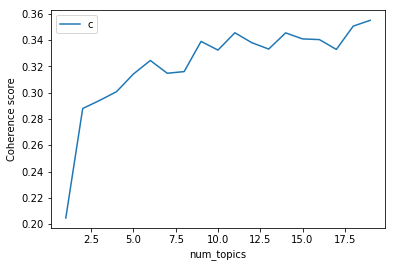

CPU times: user 2min 21s, sys: 1.2 s, total: 2min 23s
Wall time: 2min 24s


In [17]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=texts, limit=20)

In [31]:
# Set training parameters.
num_topics = 14
chunksize = 2000
passes = 20
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

ldamodel = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

In [32]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
p = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.save_html(p, 'graphs/save_14_LDA.html')

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      11.413488        1       1  0.085024 -0.037779
7      10.545245        1       2 -0.146722  0.036126
10      8.786989        1       3 -0.098590 -0.016159
5       8.545511        1       4  0.100833 -0.075099
9       7.860214        1       5 -0.010544 -0.038773
2       7.054125        1       6  0.078839  0.128151
13      6.594609        1       7  0.014509  0.031884
3       6.224712        1       8  0.034260  0.030235
8       6.210845        1       9 -0.004721  0.023140
6       6.019257        1      10  0.065653  0.050850
12      5.521895        1      11 -0.111737 -0.009532
11      5.211081        1      12 -0.040274 -0.126470
4       5.050581        1      13  0.059287 -0.080112
1       4.961446        1      14 -0.025818  0.083538, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
105   Default  1275.000000          firm  1275.000000  30.0000  30.0000
161   Default   766.000000      contract   766.000000  29.0000  29.0000
73    Default   622.000000           law   622.000000  28.0000  28.0000
239   Default   798.000000   institution   798.000000  27.0000  27.0000
235   Default   760.000000       country   760.000000  26.0000  26.0000
228   Default   281.000000      property   281.000000  25.0000  25.0000
243   Default   262.000000    regulation   262.000000  24.0000  24.0000
156   Default   398.000000    governance   398.000000  23.0000  23.0000
604   Default   206.000000      election   206.000000  22.0000  22.0000
466   Default   230.000000          land   230.000000  21.0000  21.0000
216   Default   292.000000         price   292.000000  20.0000  20.0000
390   Default   281.000000       capital   281.000000  19.0000  19.0000
89    Default   212.000000         trust   212.000000  18.0000  18.0000
83    Default   645.000000         state   645.000000  17.0000  17.0000
347   Default   182.000000       project   182.000000  16.0000  16.0000
31    Default   288.000000   transaction   288.000000  15.0000  15.0000
133   Default   169.000000        worker   169.000000  14.0000  14.0000
66    Default   415.000000         party   415.000000  13.0000  13.0000
27    Default   177.000000    corruption   177.000000  12.0000  12.0000
180   Default   235.000000       network   235.000000  11.0000  11.0000
317   Default   306.000000        growth   306.000000  10.0000  10.0000
7     Default   571.000000        policy   571.000000   9.0000   9.0000
84    Default   558.000000    government   558.000000   8.0000   8.0000
41    Default   770.000000        market   770.000000   7.0000   7.0000
403   Default   144.000000          bank   144.000000   6.0000   6.0000
130   Default   294.000000         court   294.000000   5.0000   5.0000
395   Default   155.000000           tax   155.000000   4.0000   4.0000
132   Default   155.000000         judge   155.000000   3.0000   3.0000
642   Default   174.000000     democracy   174.000000   2.0000   2.0000
118   Default   246.000000         right   246.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
257   Topic14    20.850911  institutions    71.229646   1.7750  -5.2307
652   Topic14    12.073905         north    41.348234   1.7725  -5.7771
581   Topic14    14.891749     indicator    51.936801   1.7543  -5.5673
239   Topic14   209.390360   institution   798.073935   1.6655  -2.9239
147   Topic14    23.647149          task    93.365105   1.6302  -5.1049
397   Topic14    12.698371   measurement    51.564956   1.6021  -5.7267
662   Topic14    13.634368         stock    58.097042   1.5540  -5.6556
685   Topic14    10.038791         board    42.982505   1.5491  -5.9617
432   Topic14    11.489005         prize    49.565015   1.5416  -5.8268
101   Topic14    56.920448         value   257.105878   1.4956  -4.22

In [ ]:
# Set training parameters.
num_topics = 12
chunksize = 2000
passes = 20
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

ldamodel = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
p = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.save_html(p, 'graphs/save_12_LDA.html')

In [ ]:
# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

ldamodel = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
p = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.save_html(p, 'graphs/save_10_LDA.html')

In [ ]:
# Set training parameters.
num_topics = 8
chunksize = 2000
passes = 20
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

ldamodel = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
p = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.save_html(p, 'graphs/save_8_LDA.html')

In [ ]:
# Set training parameters.
num_topics = 6
chunksize = 2000
passes = 20
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

ldamodel = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
p = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.save_html(p, 'graphs/save_6_LDA.html')

In [ ]:
# Set training parameters.
num_topics = 4
chunksize = 2000
passes = 20
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

ldamodel = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
p = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.save_html(p, 'graphs/save_4_LDA.html')

In [ ]:
# ldamodel = LdaModel(corpus=corpus, num_topics=8, id2word=dictionary)
# Set training parameters.
num_topics = 3
chunksize = 2000
passes = 20
iterations = 400
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

ldamodel = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
p = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.save_html(p, 'graphs/save_3_LDA.html')

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)